# 🌅 Source data
## Publishers Weekly Annual Lists

https://en.wikipedia.org/wiki/Publishers_Weekly_lists_of_bestselling_novels_in_the_United_States

Якщо хочете погратися з іншими джерелами:
* https://www.amazon.com/Best-Sellers-Books/zgbs/books
* https://www.goodreads.com/list/show/109089.Wiki_best_selling_books_list
* https://en.wikipedia.org/wiki/Lists_of_The_New_York_Times_number-one_books

In [ ]:
def read_source_data(path_to_file):
    with open(path_to_file, "r", encoding="utf-8") as f:
        return f.read()

path_to_file = 'source_data.txt'
books_raw = read_source_data(path_to_file)

In [ ]:
books_raw.split('\n')[:20]

['1970',
 '',
 '    Love Story by Erich Segal',
 "    The French Lieutenant's Woman by John Fowles",
 '    Islands in the Stream by Ernest Hemingway',
 '    The Crystal Cave by Mary Stewart',
 '    Great Lion of God by Taylor Caldwell',
 '    QB VII by Leon Uris',
 "    The Gang That Couldn't Shoot Straight by Jimmy Breslin",
 '    The Secret Woman by Victoria Holt',
 '    Travels with My Aunt by Graham Greene',
 '    Rich Man, Poor Man by Irwin Shaw',
 '',
 '1971',
 '',
 '    Wheels by Arthur Hailey',
 '    The Exorcist by William P. Blatty',
 '    The Passions of the Mind by Irving Stone',
 '    The Day of the Jackal by Frederick Forsyth',
 '    The Betsy by Harold Robbins']

In [ ]:
import pandas as pd
import re


def parse_books(text):
    lines = text.split('\n')
    books = []
    current_year = None
    place = 0

    for line in lines:
        line = line.strip().strip('"').strip("'")
        if not line:
            continue
        if re.fullmatch(r'\d{4}', line):
            current_year = int(line)
            place = 0
        elif ' by ' in line and current_year:
            place += 1
            try:
                title, author = line.rsplit(' by ', 1)
                books.append({
                    'year': current_year,
                    'place': place,
                    'title': title.strip(),
                    'author': author.strip()
                })
            except ValueError:
                continue

    return pd.DataFrame(books)


books_df = parse_books(books_raw)
books_df.head()

,year,place,title,author
0,1970,1,Love Story,Erich Segal
1,1970,2,The French Lieutenant's Woman,John Fowles
2,1970,3,Islands in the Stream,Ernest Hemingway
3,1970,4,The Crystal Cave,Mary Stewart
4,1970,5,Great Lion of God,Taylor Caldwell


# ⚙️ Data Enrichment API

In [ ]:
import requests
import time


def fetch_book_info(title, author=None, sleep=1.0):

    try:
        query = f"intitle:{title}"

        if author:
            query += f"+inauthor:{author}"

        url = "https://www.googleapis.com/books/v1/volumes"
        params = {"q": query, "maxResults": 1}

        response = requests.get(url, params=params)
        time.sleep(sleep)

        if response.status_code != 200:
            response.raise_for_status()

        data = response.json()

        if "items" not in data:
            return None

        book = data["items"][0]["volumeInfo"]

        return {
            "title": book.get("title"),
            "authors": ", ".join(book.get("authors", [])),
            "categories": ", ".join(book.get("categories", [])),
            "pageCount": book.get("pageCount"),
            "averageRating": book.get("averageRating"),
            "ratingsCount": book.get("ratingsCount"),
            "publishedDate": book.get("publishedDate"),
            "description": (book.get("description") or "")[:300] + "...",
        }

    except requests.exceptions.RequestException as e:
        print(f"Error: {e}")
        return None


if __name__ == "__main__":
    result = fetch_book_info("Stand", "Stephen King", sleep=5)
    if result:
        for k, v in result.items():
            print(f"{k}: {v}")
    else:
        print("No information about this book")

title: The Stand
authors: Stephen King
categories: Fiction
pageCount: 1201
averageRating: None
ratingsCount: None
publishedDate: 2012-08-07
description: #1 BESTSELLER • NOW A PARAMOUNT+ LIMITED SERIES • Stephen King’s apocalyptic vision of a world blasted by plague and tangled in an elemental struggle between good and evil remains as riveting—and eerily plausible—as when it was first published. One of The Atlantic’s Great American Novels of the Past...


In [ ]:
import csv


data = pd.read_csv(
    'book_info.csv',
    delimiter=';',
    quoting=csv.QUOTE_NONE,
    encoding='utf-8',
    on_bad_lines='skip'
)

data.head()

,title,author,categories,pageCount,averageRating,ratingsCount,publishedDate,description
0,1876,Gore Vidal,Fiction,385.0,NaN,NaN,2018-08-22,The third volume of Gore Vidal's magnificent s...
1,"""""""...And Ladies of the Club""""""",Helen Hooven Santmyer,NaN,1433.0,NaN,NaN,1986,NaN
2,11/22/63,Stephen King,Fiction,866.0,4.0,2.0,2011-11-08,"ON NOVEMBER 22, 1963, THREE SHOTS RANG OUT IN ..."
3,2010: Odyssey Two,Arthur C. Clarke,Fiction,328.0,3.0,1.0,1982,"""""""A daring romp through the solar system and ..."
4,A Court of Mist and Fury,Sarah J. Maas,Fiction,678.0,4.5,4.0,2016-05-03,The second instalment of the GLOBAL PHENOMENON...


In [ ]:
books_df['title_clean'] = books_df['title'].str.strip().str.replace('"', '')
data['title_clean'] = data['title'].str.strip().str.replace('"', '')

In [ ]:
def enrich_row(row):
    df_merged = pd.merge(
        row,
        data.drop(columns=['title', 'author']),
        on='title_clean',
        how='left'
        )

    df_merged = df_merged.drop(columns=['title'])
    df_merged = df_merged.rename(columns={'title_clean': 'title'})

    return df_merged

books_info_df = enrich_row(books_df)

books_info_df.head()

,year,place,author,title,categories,pageCount,averageRating,ratingsCount,publishedDate,description
0,1970,1,Erich Segal,Love Story,Fiction,229.0,4.0,18.0,2011-11-01,"“Funny, touching and infused with wonder, as a..."
1,1970,2,John Fowles,The French Lieutenant's Woman,NaN,518.0,NaN,NaN,1969,NaN
2,1970,3,Ernest Hemingway,Islands in the Stream,Fiction,496.0,NaN,NaN,2014-05-22,"First published in 1970, nine years after Hemi..."
3,1970,4,Mary Stewart,The Crystal Cave,NaN,548.0,NaN,NaN,NaN,NaN
4,1970,5,Taylor Caldwell,Great Lion of God,NaN,669.0,NaN,NaN,1973,NaN


In [ ]:
import requests
import time


def get_wikipedia_author_summary(author_name, sleep=0.2):
    url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "exintro": True,
        "explaintext": True,
        "redirects": 1,
        "titles": author_name
    }

    try:
        resp = requests.get(url=url, params=params)
        resp.raise_for_status()
        time.sleep(sleep)
        data = resp.json()


        dict_pages = data.get("query", {}).get("pages", {})
        if not dict_pages:
            return ""

        value = list(dict_pages.keys())[0]
        text = dict_pages[value].get("extract", "")
        return text

    except Exception:
        return ""

print(get_wikipedia_author_summary("Victor Pelevin"))

Victor Olegovich Pelevin (Russian: Виктор Олегович Пелевин, IPA: [ˈvʲiktər ɐˈlʲeɡəvʲɪtɕ pʲɪˈlʲevʲɪn]; born 22 November 1962) is a Russian fiction writer. His novels include Omon Ra (1992), The Life of Insects (1993), Chapayev and Void (1996), and Generation P (1999). He is a laureate of multiple literary awards including the Russian Little Booker Prize (1993) and the Russian National Bestseller (2004), the former for the short story collection The Blue Lantern (1991). In 2011 he was nominated for the Nobel prize in Literature. His books are multi-layered postmodernist (disputed) texts fusing elements of pop culture and esoteric philosophies while carrying conventions of the science fiction genre. Some critics relate his prose to the New sincerity literary movement.




# 📊 EDA & Visualizations

1. Preview Your Data
    * Are there any missing values?
    * Are all data types correct (e.g., dates as datetime)?
    * Any unexpected columns?
2. Check for Duplicates
    * Some books may appear twice under different metadata.
3. Clean Up
    * Is everything okay with dates?
    * Are all authors uniformed?
    * Are there some special symbols we don't need in our data?
4. Look at Summary Statistics
    * Are there any obvious outliers (very long books, very high/low ratings)?
5. Visualize Key Distributions
6. Analyze Trends Over Time
7. Explore the Category Data
8. Spot Outliers
9. Word Cloud or Sentiment (Optional)

In [ ]:
books_info_df[['year', 'place', 'title', 'author', 'categories', 'pageCount',
       'averageRating', 'ratingsCount', 'publishedDate', 'description']].to_csv('book_info_df.csv')

🔹 1. Descriptive Statistics

* Average, median, min, max of:
    * averageRating
    * ratingsCount
    * pageCount
* Yearly counts of books published
* Rating distribution (histogram or KDE)

🔹 2. Time-based Trends
* Average rating per year (line plot)
* Average page count per year
* Ratings count trend over time
* Number of bestsellers per author per year

🔹 3. Categorical Distributions
* Top N authors by number of books (bar chart)
* Top genres/categories (bar chart or pie chart)
* Genre distribution by year (stacked bar plot)
* Number of books per genre

🔹 4. Correlations & Relationships
* Correlation matrix between numeric features (averageRating, ratingsCount, pageCount)
* Scatterplot: rating vs. ratings count (highlighting “hidden gems” = high rating, low count)
* Scatterplot: page count vs. rating (do longer books tend to be rated higher?)

🔹 5. Outlier Detection

* Detect books with unusually high/low ratings
* Find books with extreme page counts
* Boxplots for ratings and page counts

🔹 6. Textual/NLP Insights

* Word cloud of most common words in description
* Frequency of common words by genre (optional)
* Sentiment analysis of descriptions (using TextBlob or VADER)

🔹 7. Grouped Insights

* Average rating by author
* Average rating by genre
* Total books published per author
* Most popular genre per year

🔹 8. "Best of" Lists

* Highest-rated book overall
* Highest-rated book per year
* Book with most pages
* Book with most ratings

🔹 9. Advanced (Optional/Bonus)

* Trend line of genre popularity over time
* Normalized rating per year (z-score) to find standout books
* Use statsmodels or scipy.stats to:
    * Test if ratings differ significantly by genre or author
    * Model ratings based on pages/genre/author

## 🔨 Data Enrichment Generated

In [ ]:
# Helper function to normalize publishedDate to datetime
from datetime import datetime


def normalize_date(date_str):

    if not date_str or not isinstance(date_str, str):
        return None

    try:
        if len(date_str) == 4:
            date_str += "-01-01"
            # Year only, assume January 1st

        elif len(date_str) == 7:
            date_str += "-01"
            # Year and month only, assume the 1st day

        elif len(date_str) != 10:
            return None
            # Full date already

        return datetime.strptime(date_str, "%Y-%m-%d")

    except Exception:
        return None


print(normalize_date("1985"))


1985-01-01 00:00:00


In [ ]:
# Function to decide "correct" date
def determine_best_date(row):
    bestseller_year = int(row['year'])
    pub_date = row['normalizedPublishedDate']

    if pd.isnull(pub_date):
        return pd.Timestamp(f'{bestseller_year}-01-01')

    year_diff = abs(pub_date.year - bestseller_year)

    if year_diff <= 1:
        return pub_date
    elif pub_date.year < bestseller_year:
        return pub_date
    else:
        return pd.Timestamp(f'{bestseller_year}-01-01')


books_info_df['normalizedPublishedDate'] = books_info_df['publishedDate'].astype(str).apply(normalize_date)
books_info_df['finalBookDate'] = books_info_df.apply(determine_best_date, axis=1)

books_info_df = books_info_df.drop(columns=['publishedDate'])
books_info_df = books_info_df.rename(columns={'normalizedPublishedDate': 'publishedDate'})


books_info_df.head()

,year,place,author,title,categories,pageCount,averageRating,ratingsCount,description,publishedDate,finalBookDate
0,1970,1,Erich Segal,Love Story,Fiction,229.0,4.0,18.0,"“Funny, touching and infused with wonder, as a...",2011-11-01,1970-01-01
1,1970,2,John Fowles,The French Lieutenant's Woman,NaN,518.0,NaN,NaN,NaN,1969-01-01,1969-01-01
2,1970,3,Ernest Hemingway,Islands in the Stream,Fiction,496.0,NaN,NaN,"First published in 1970, nine years after Hemi...",2014-05-22,1970-01-01
3,1970,4,Mary Stewart,The Crystal Cave,NaN,548.0,NaN,NaN,NaN,NaT,1970-01-01
4,1970,5,Taylor Caldwell,Great Lion of God,NaN,669.0,NaN,NaN,NaN,1973-01-01,1970-01-01


In [ ]:
# Book Age - Helps you understand how long it took a book to become a bestseller.
books_info_df['bookAge'] = books_info_df['year'] - books_info_df['finalBookDate'].dt.year

In [ ]:
# Description Length - Length of book descriptions could be used for NLP or popularity prediction.
books_info_df['descriptionLength'] = books_info_df['description'].fillna('').apply(len)

In [ ]:
# Author Book Count - Total books by the same author in the dataset (indicates popularity).
books_info_df['authorBookCount'] = books_info_df.groupby('author')['author'].transform('count')

In [ ]:
# Title length
books_info_df['titleLength'] = books_info_df['title'].fillna('').apply(len)

## 👀 Looking at data

In [ ]:
# display duplicates
duplicates = books_info_df[books_info_df.duplicated(subset=['title', 'author', 'year'], keep=False)]

print(duplicates[['title', 'author', 'year']])

                            title      author  year
464  Me Before You (movie tie-in)  Jojo Moyes  2016
468  Me Before You (movie tie-in)  Jojo Moyes  2016


In [ ]:
# Identify missing values
print(books_info_df.isnull().sum())

year                   0
place                  0
author                 0
title                  0
categories            64
pageCount             32
averageRating        339
ratingsCount         339
description           70
publishedDate         25
finalBookDate          0
bookAge                0
descriptionLength      0
authorBookCount        0
titleLength            0
dtype: int64


In [ ]:
# Check for outliers in ratings
books_info_df['averageRating'].describe()

,averageRating
count,211.000000
mean,4.236967
std,0.797770
min,1.000000
25%,4.000000
50%,4.500000
75%,5.000000
max,5.000000


In [ ]:
# Check for outliers in page count
books_info_df['pageCount'].describe()

,pageCount
count,518.000000
mean,460.335907
std,315.750347
min,0.000000
25%,282.750000
50%,415.000000
75%,557.250000
max,2964.000000


In [ ]:
# Detect outliers using IQR method for rating

books_cleaned_df = books_info_df.dropna()

Q1_rating = books_cleaned_df["averageRating"].quantile(0.25)
Q3_rating = books_cleaned_df["averageRating"].quantile(0.75)
IQR_rating = Q3_rating - Q1_rating
rating_outliers = books_cleaned_df[
    (books_cleaned_df["averageRating"] < (Q1_rating - 1.5 * IQR_rating))
    | (books_cleaned_df["averageRating"] > (Q3_rating + 1.5 * IQR_rating))
]
rating_outliers[["title", "averageRating"]]

,title,averageRating
115,Masquerade,1.0
368,Beach Road,1.0
391,The Associate,2.0
518,The Song of Achilles,1.0


In [ ]:
# Detect outliers using IQR method for page Count
Q1_pgcount = books_cleaned_df["pageCount"].quantile(0.25)
Q3_pgcount = books_cleaned_df["pageCount"].quantile(0.75)
IQR_pgcount = Q3_pgcount - Q1_pgcount
pgcount_outliers = books_cleaned_df[
    (books_cleaned_df["pageCount"] < (Q1_pgcount - 1.5 * IQR_pgcount))
    | (books_cleaned_df["pageCount"] > (Q3_pgcount + 1.5 * IQR_pgcount))
]
pgcount_outliers[["title", "pageCount"]]

,title,pageCount
127,North and South,1143.0
160,It,1488.0
197,The Pillars of the Earth,1158.0
206,The Stand,1562.0
211,The Sum of All Fears,1296.0
261,Executive Orders,1377.0
302,The Bear and the Dragon,1154.0
387,Scarpetta,1907.0
414,A Dance with Dragons,1016.0


averageRating — outliers number: 4


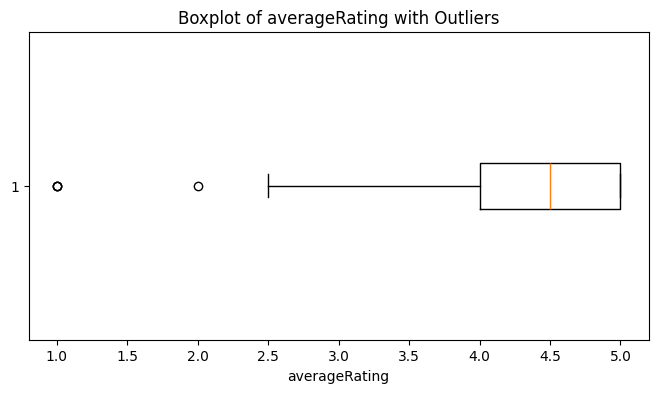

pageCount — outliers number: 9


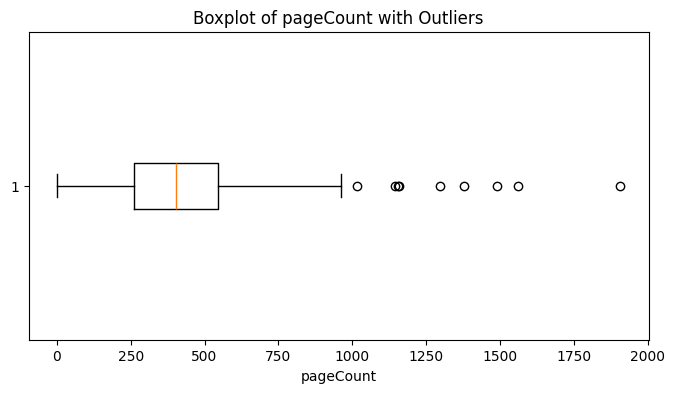

titleLength — outliers number: 4


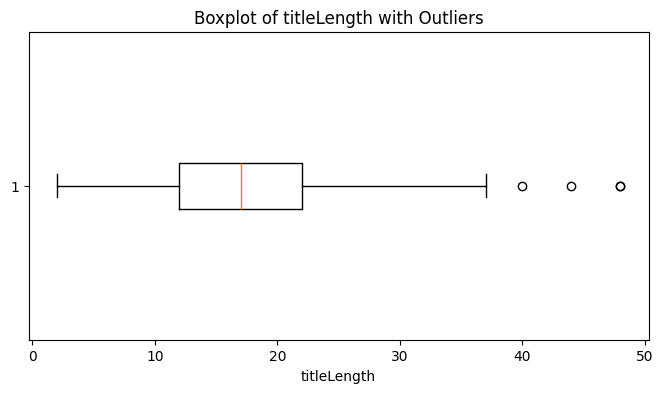

In [ ]:
# Function to detect outliers using the IQR method and visualize them
import matplotlib.pyplot as plt


def detect_and_plot_outliers(df, column_name):

    data = df[column_name].dropna()

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    print(f"{column_name} — outliers number: {len(outliers)}")

    plt.figure(figsize=(8, 4))
    plt.boxplot(data, vert=False)
    plt.title(f'Boxplot of {column_name} with Outliers')
    plt.xlabel(column_name)
    plt.show()


detect_and_plot_outliers(books_cleaned_df, 'averageRating')
detect_and_plot_outliers(books_cleaned_df, 'pageCount')
detect_and_plot_outliers(books_cleaned_df, 'titleLength')

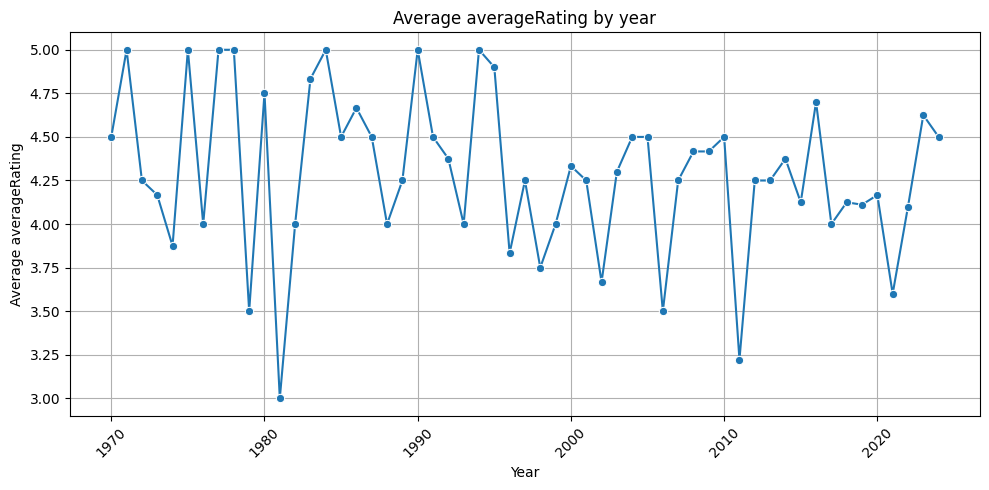

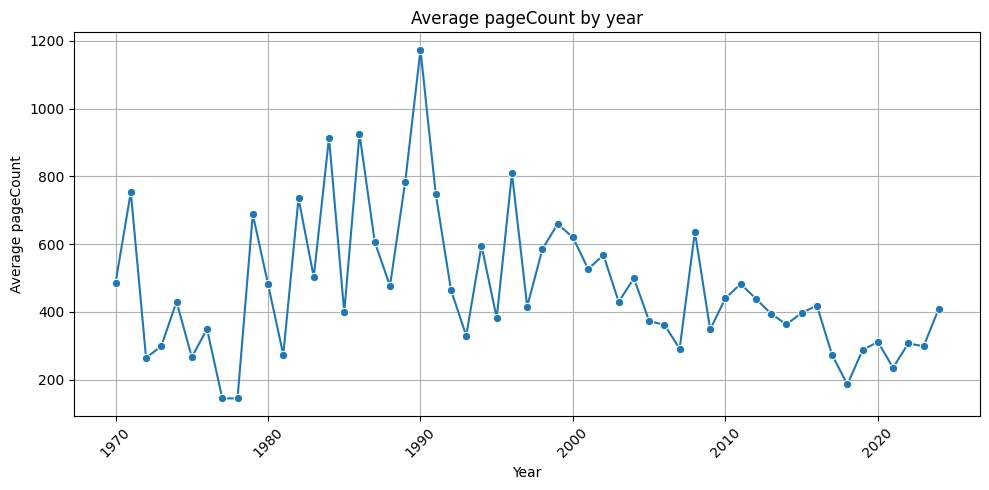

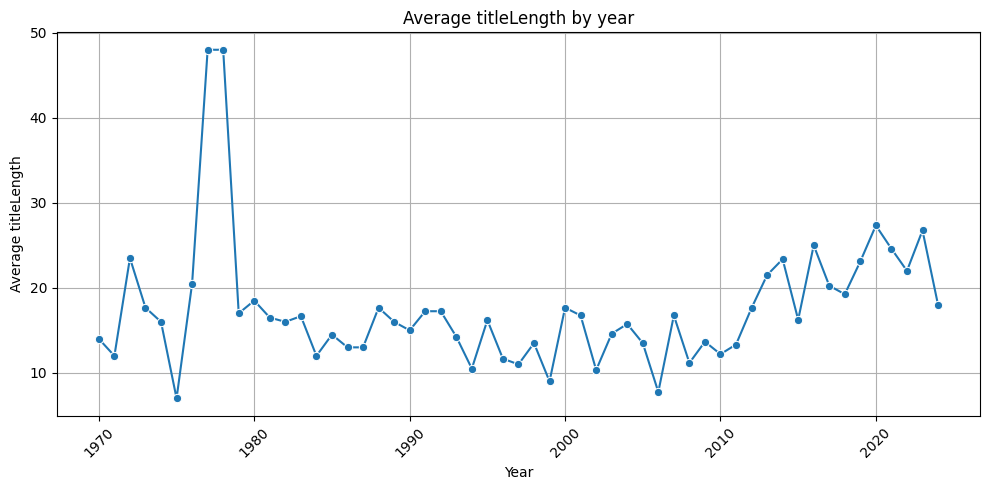

In [ ]:
import seaborn as sns


def dynamic_plots(df_cleaned, column_name):

    avg_per_year = df_cleaned.groupby('year')[column_name].mean().reset_index()


    plt.figure(figsize=(10, 5))

    sns.lineplot(
        x='year',
        y=column_name,
        data=avg_per_year,
        marker='o'
    )

    plt.title(f'Average {column_name} by year')
    plt.xlabel('Year')
    plt.ylabel(f'Average {column_name}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


dynamic_plots(books_cleaned_df, 'averageRating')
dynamic_plots(books_cleaned_df, 'pageCount')
dynamic_plots(books_cleaned_df, 'titleLength')

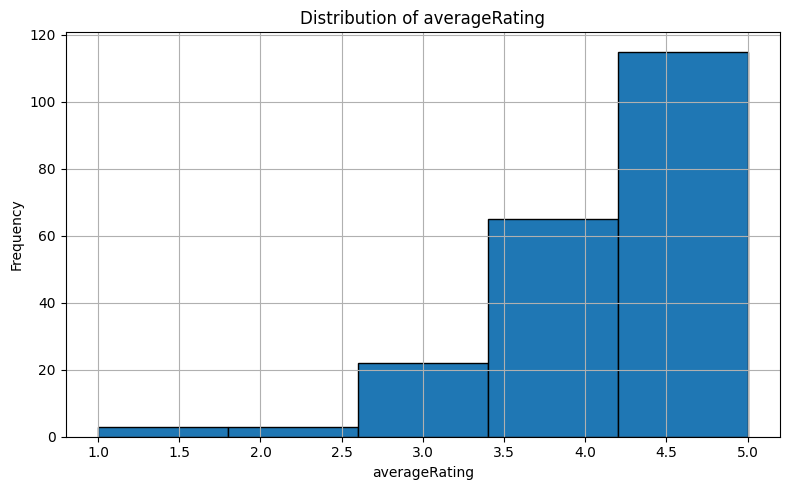

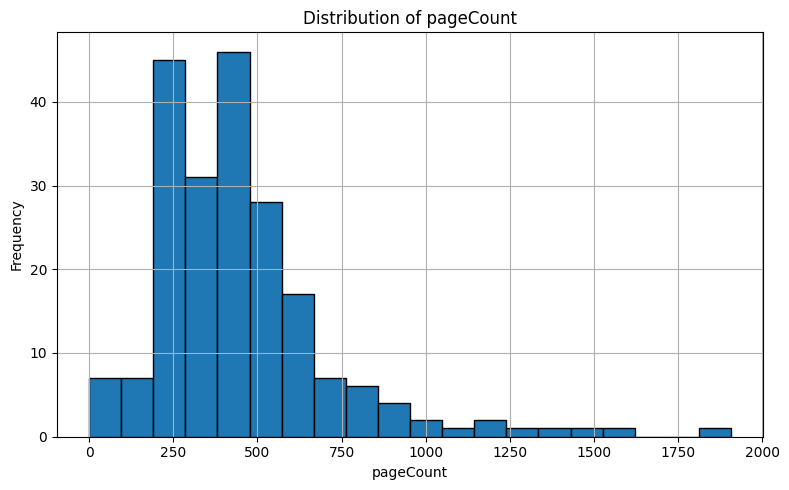

In [ ]:
def distro_plots(df_cleaned, column_name, bins = 5):

    plt.figure(figsize=(8, 5))

    plt.hist(df_cleaned[column_name], bins=bins, edgecolor='black')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')

    plt.grid(True)
    plt.tight_layout()
    plt.show()


distro_plots(books_cleaned_df, column_name = 'averageRating', bins = 5)
distro_plots(books_cleaned_df, column_name = 'pageCount', bins = 20)

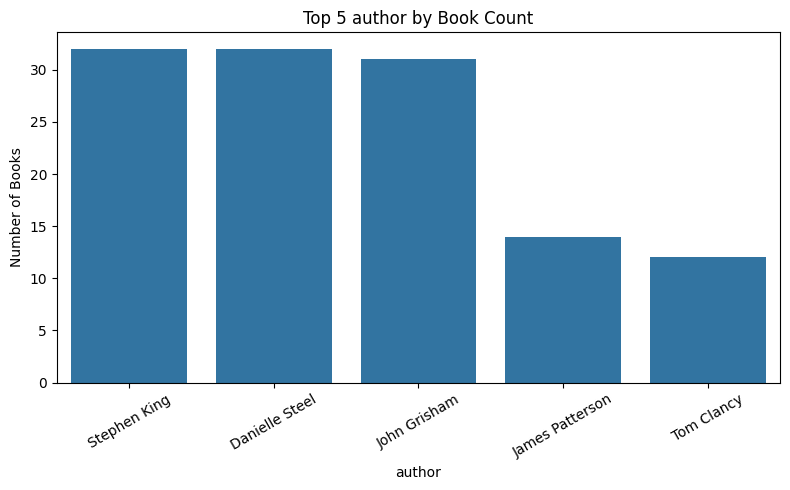

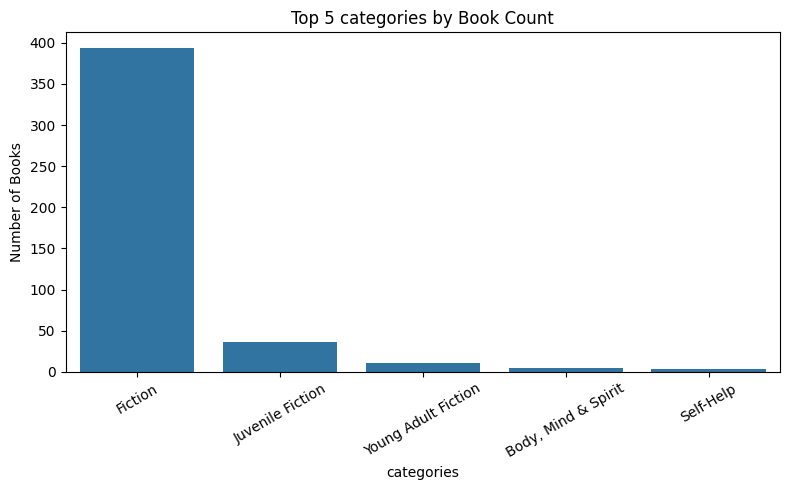

In [ ]:
def most_common_plot(df_cleaned, column_name, top_n = 5):

    top_columns = df_cleaned[column_name].value_counts().head(top_n)
    top_order = top_columns.index
    top_counts = df_cleaned[df_cleaned[column_name].isin(top_order)]


    plt.figure(figsize=(8, 5))
    sns.countplot(
        x =column_name,
        data = top_counts,
        order=top_order
        )

    plt.title(f"Top 5 {column_name} by Book Count")
    plt.xlabel(column_name)
    plt.ylabel("Number of Books")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


most_common_plot(books_info_df, 'author', top_n = 5)
most_common_plot(books_info_df, 'categories', top_n = 5)

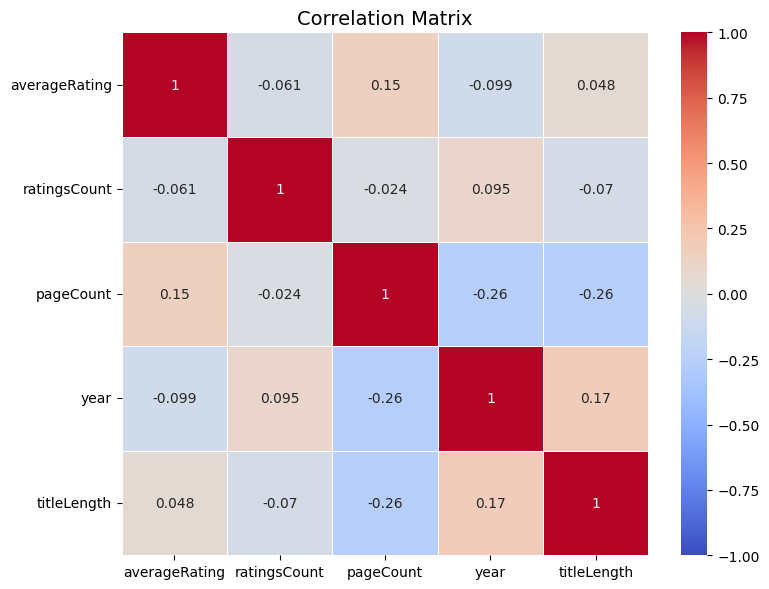

In [ ]:
def plot_correlation_matrix(dataframe, columns=None):

    heat_df = dataframe[columns]

    co_mtx = heat_df.corr(numeric_only=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(co_mtx, cmap="coolwarm", annot=True, vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Correlation Matrix", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_correlation_matrix(
    books_cleaned_df,
    columns=["averageRating", "ratingsCount", "pageCount", "year", "titleLength"],
)

# Also...

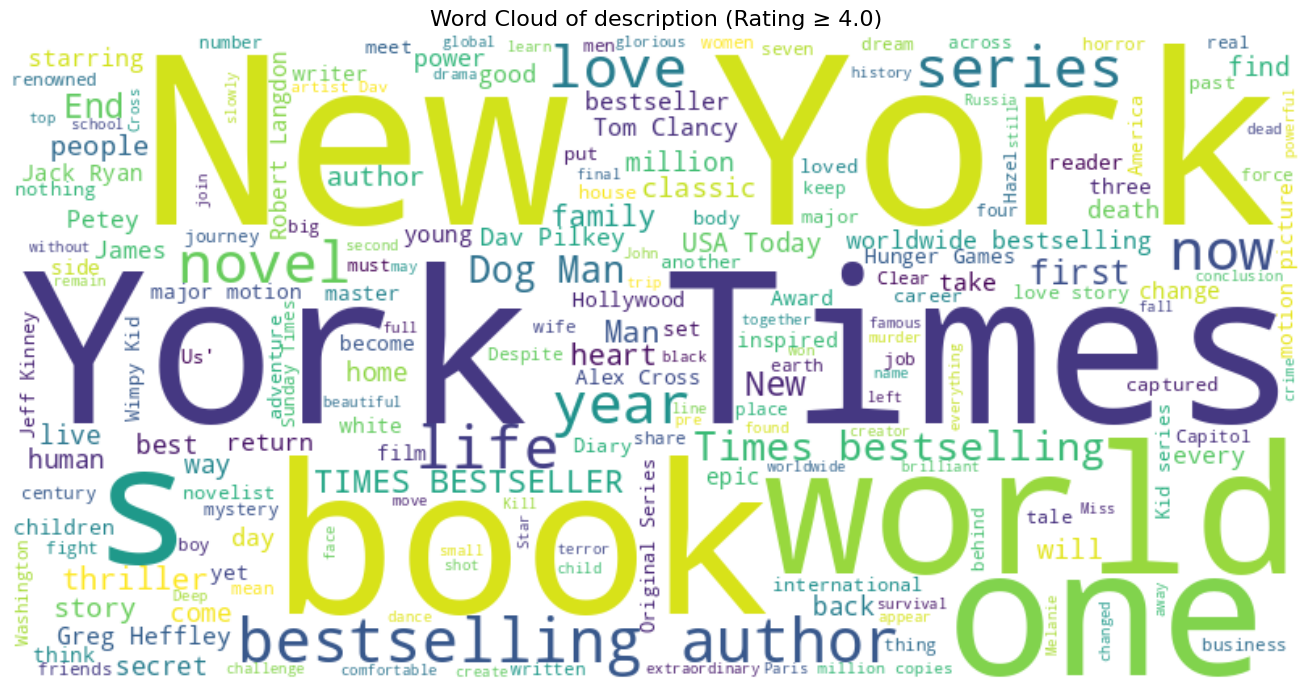

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


def word_cloud_plot(df, text_field, rating_threshold):

    filtered_df = df[df['averageRating'] >= rating_threshold]

    text = ' '.join(filtered_df[text_field].dropna().astype(str))

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords,
        colormap='viridis',
        collocations=True
    ).generate(text)


    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {text_field} (Rating ≥ {rating_threshold})', fontsize=16)
    plt.tight_layout()
    plt.show()


rating_threshold = 4.0

word_cloud_plot(books_cleaned_df, 'description', rating_threshold)

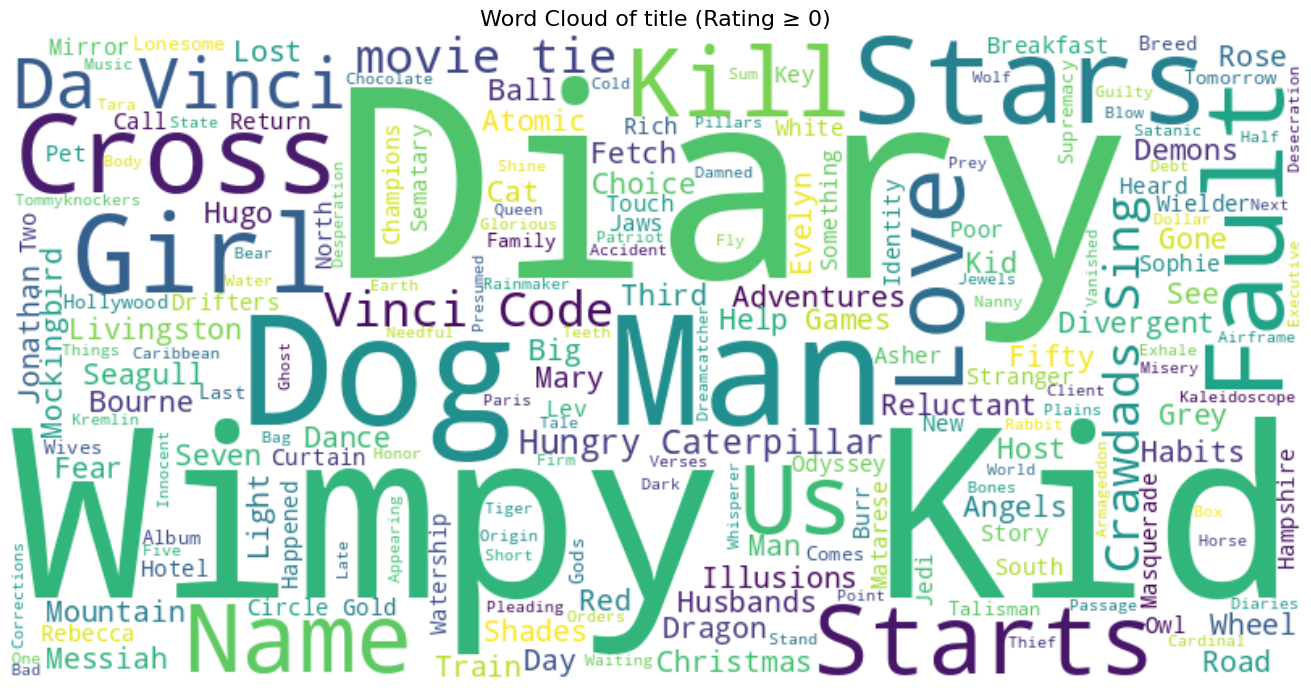

In [ ]:
word_cloud_plot(books_cleaned_df, 'title', rating_threshold = 0)

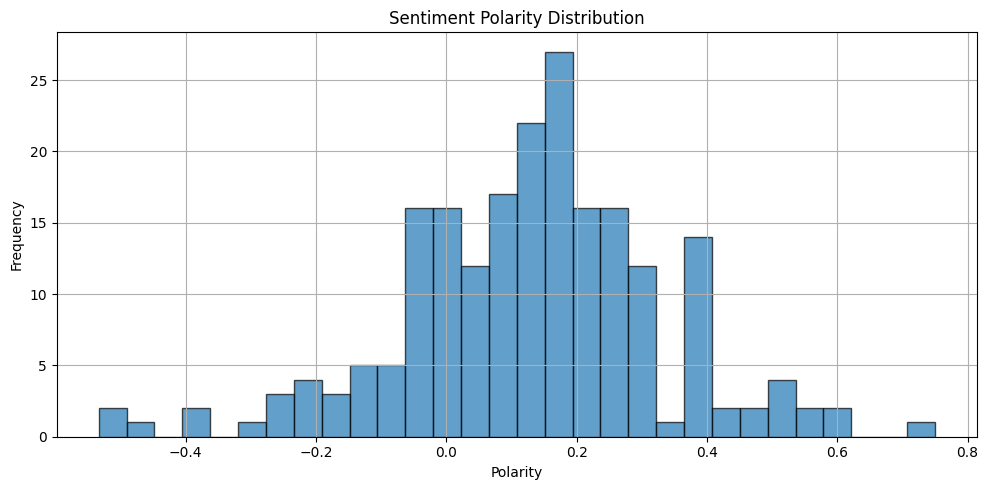

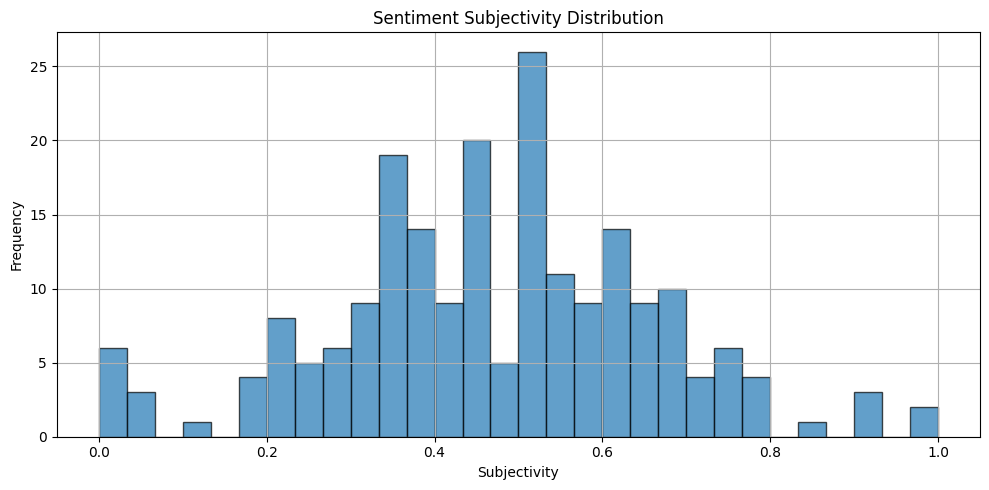

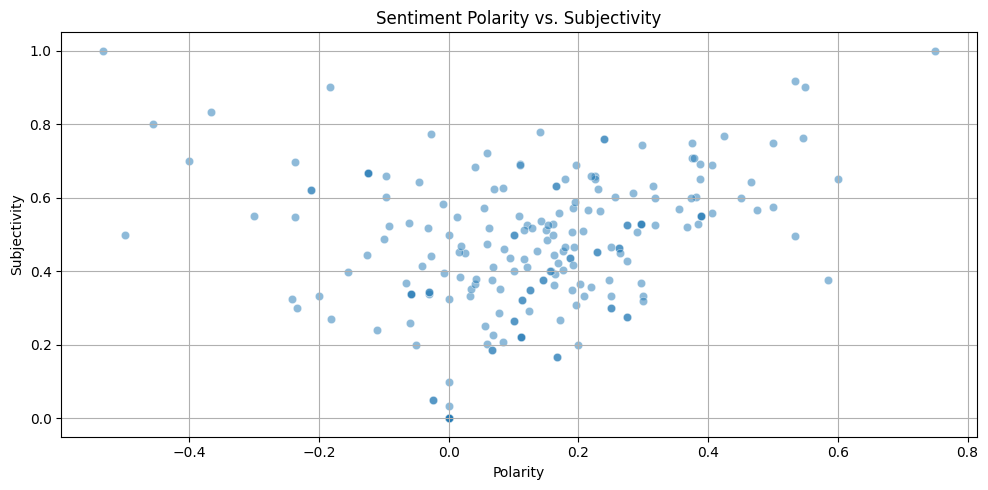

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns


def sentiment_analysis_with_plots(df):
    """
    Perform sentiment analysis on book descriptions and visualize the results.

    Parameters:
    - df: DataFrame with a 'description' column.
    """

    df = df.copy()

    df['sentiment_polarity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else None)
    df['sentiment_subjectivity'] = df['description'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else None)

    # polarity plot
    plt.figure(figsize=(10, 5))
    plt.hist(df['sentiment_polarity'].dropna(), bins=30, alpha=0.7, edgecolor='black')
    plt.title("Sentiment Polarity Distribution")
    plt.xlabel("Polarity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # subjectivity plot
    plt.figure(figsize=(10, 5))
    plt.hist(df['sentiment_subjectivity'].dropna(), bins=30, alpha=0.7, edgecolor='black')
    plt.title("Sentiment Subjectivity Distribution")
    plt.xlabel("Subjectivity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Polarity vs. Subjectivity plot
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df, x='sentiment_polarity', y='sentiment_subjectivity', alpha=0.5)
    plt.title("Sentiment Polarity vs. Subjectivity")
    plt.xlabel("Polarity")
    plt.ylabel("Subjectivity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df


books_sentiments = sentiment_analysis_with_plots(books_cleaned_df)

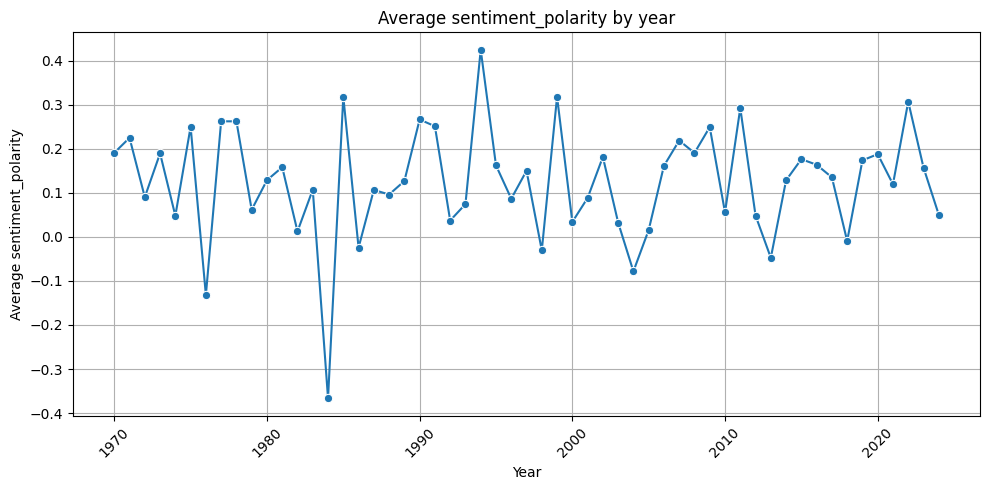

In [ ]:
books_sentiments_short = books_sentiments[books_sentiments['description'].str.len() > 0]

dynamic_plots(books_sentiments_short, 'sentiment_polarity')

In [ ]:
books_sentiments_short.sort_values("sentiment_polarity")[
    ["title", "author", "sentiment_polarity", "sentiment_subjectivity"]
].head(10)

,title,author,sentiment_polarity,sentiment_subjectivity
160,It,Stephen King,-0.533333,1.000000
310,Desecration,Jerry B. Jenkins and Tim LaHaye,-0.500000,0.500000
69,A Stranger in the Mirror,Sidney Sheldon,-0.455556,0.800000
485,A Wrinkle in Time,Madeleine L’Engle,-0.400000,0.700000
140,The Talisman,Stephen King and Peter Straub,-0.366667,0.833333
132,Pet Sematary,Stephen King,-0.300000,0.550000
432,The House of Hades,Rick Riordan,-0.241667,0.325000
337,Blow Fly,Patricia Cornwell,-0.237879,0.697348
434,Sycamore Row,John Grisham,-0.237500,0.546875
511,Diary of a Wimpy Kid: Big Shot,Jeff Kinney,-0.233333,0.300000
